<a href="https://colab.research.google.com/github/vngeno/E-COMMERCE-RECOMMENDATION-SYSTEM-/blob/Collaborative-Based-Filtering/PytorchCollaborative.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Collaborative Filterting

In [1]:
#Import libraries required
import math
import copy
import zipfile
from textwrap import wrap
from pathlib import Path
from itertools import zip_longest
from collections import defaultdict
from urllib.error import URLError
from urllib.request import urlopen

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F 
from torch.optim.lr_scheduler import _LRScheduler

In [2]:
#State the random state
def set_random_seed(state=1):
    gens = (np.random.seed, torch.manual_seed, torch.cuda.manual_seed)
    for set_state in gens:
        set_state(state)

RANDOM_STATE = 1
set_random_seed(RANDOM_STATE)

Dataset Preview

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#Load the dataset and preview the columns
df = pd.read_csv('/content/drive/Shareddrives/Team Stars/Data/df_clean.csv',index_col=0)
df.columns

Index(['id', 'name', 'brand', 'primarycategories', 'manufacturernumber',
       'reviews_dorecommend', 'reviews_numhelpful', 'reviews_rating',
       'reviews_text', 'reviews_title', 'reviews_username'],
      dtype='object')

In [5]:
#label encode the id and username to get the userid and productid
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df.id=le.fit_transform(df.id)
df.reviews_username=le.fit_transform(df.reviews_username)
df.reviews_rating=le.fit_transform(df.reviews_rating)


In [6]:
#Rename the columns
df=df.rename(columns={'id':'productId','reviews_username':'userId','reviews_rating':'rating','brand':'brand','name':'title'})
df.columns

Index(['productId', 'title', 'brand', 'primarycategories',
       'manufacturernumber', 'reviews_dorecommend', 'reviews_numhelpful',
       'rating', 'reviews_text', 'reviews_title', 'userId'],
      dtype='object')

In [7]:
#Define the ratimg dataset
ratings=df[['userId','productId','rating']]
ratings.head()

,userId,productId,rating
0,8417,21,2
1,5201,21,3
2,6994,21,4
3,8769,21,4
4,8713,21,4


In [8]:
#Define the product dataset
products=df[['productId','title','brand']]
products.head()

,productId,title,brand
0,21,AmazonBasics AAA Performance Alkaline Batterie...,Amazonbasics
1,21,AmazonBasics AAA Performance Alkaline Batterie...,Amazonbasics
2,21,AmazonBasics AAA Performance Alkaline Batterie...,Amazonbasics
3,21,AmazonBasics AAA Performance Alkaline Batterie...,Amazonbasics
4,21,AmazonBasics AAA Performance Alkaline Batterie...,Amazonbasics


In [9]:
#Creating a cross-tabular view of users vs product
def tabular_preview(ratings, n=15):
    #Group by users
    user_groups = ratings.groupby('userId')['rating'].count()
    top_users = user_groups.sort_values(ascending=False)[:15]

    #group by products
    product_groups = ratings.groupby('productId')['rating'].count()
    top_products = product_groups.sort_values(ascending=False)[:15]

    top = (
        ratings.
        join(top_users, rsuffix='_r', how='inner', on='userId').
        join(top_products, rsuffix='_r', how='inner', on='productId'))

    return pd.crosstab(top.userId, top.productId, top.rating, aggfunc=np.sum)

In [10]:
#Preview the crosstab
tabular_preview(ratings, products)

productId,7,15,18,21,22,25,27,32,33,34,39,40,44,48,51
userId,,,,,,,,,,,,,,,
219,NaN,NaN,3.0,NaN,14.0,3.0,4.0,14.0,3.0,15.0,NaN,8.0,11.0,NaN,4.0
323,NaN,4.0,4.0,NaN,13.0,4.0,4.0,13.0,4.0,10.0,NaN,13.0,7.0,NaN,NaN
701,NaN,NaN,10.0,NaN,8.0,10.0,4.0,8.0,2.0,9.0,NaN,8.0,9.0,NaN,NaN
739,NaN,NaN,6.0,NaN,14.0,6.0,NaN,14.0,6.0,6.0,NaN,3.0,6.0,NaN,6.0
1151,942.0,NaN,NaN,2037.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4730,36.0,NaN,NaN,121.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5588,35.0,NaN,NaN,53.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9496,NaN,NaN,22.0,NaN,4.0,11.0,4.0,4.0,15.0,10.0,10.0,NaN,18.0,4.0,10.0
9779,NaN,4.0,19.0,NaN,8.0,19.0,11.0,8.0,12.0,24.0,NaN,8.0,24.0,4.0,4.0


**Dataset Preparation**

In [11]:
#Create a dataset
def create_dataset(ratings, top=None):
    if top is not None:
        ratings.groupby('userId')['rating'].count()
    
    #get the unique users
    unique_users = ratings.userId.unique()
    user_to_index = {old: new for new, old in enumerate(unique_users)}
    new_users = ratings.userId.map(user_to_index)
    
    #Get the unique products
    unique_products = ratings.productId.unique()
    product_to_index = {old: new for new, old in enumerate(unique_products)}
    new_products = ratings.productId.map(product_to_index)
    
    n_users = unique_users.shape[0]
    n_products = unique_products.shape[0]
    
    X = pd.DataFrame({'user_id': new_users, 'product_id': new_products})
    y = ratings['rating'].astype(np.float32)
    return (n_users, n_products), (X, y), (user_to_index, product_to_index)


In [12]:
#Create the embeddings between users and products
(n, m), (X, y), _ = create_dataset(ratings)
print(f'Embeddings: {n} users, {m} products')
print(f'Dataset shape: {X.shape}')
print(f'Target shape: {y.shape}')

Embeddings: 16269 users, 65 products
Dataset shape: (28332, 2)
Target shape: (28332,)


In [13]:
#Iterate among the reviews
class ReviewsIterator:
    
    def __init__(self, X, y, batch_size=32, shuffle=True):
        X, y = np.asarray(X), np.asarray(y)
        
        if shuffle:
            index = np.random.permutation(X.shape[0])
            X, y = X[index], y[index]
            
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n_batches = int(math.ceil(X.shape[0] // batch_size))
        self._current = 0
        
    def __iter__(self):
        return self
    
    def __next__(self):
        return self.next()
    
    def next(self):
        if self._current >= self.n_batches:
            raise StopIteration()
        k = self._current
        self._current += 1
        bs = self.batch_size
        return self.X[k*bs:(k + 1)*bs], self.y[k*bs:(k + 1)*bs]

In [14]:
def batches(X, y, bs=32, shuffle=True):
    for xb, yb in ReviewsIterator(X, y, bs, shuffle):
        xb = torch.LongTensor(xb)
        yb = torch.FloatTensor(yb)
        yield xb, yb.view(-1, 1)

for x_batch, y_batch in batches(X, y, bs=4):
    print(x_batch)
    print(y_batch)
    break

tensor([[ 8261,     6],
        [12801,    57],
        [ 9118,    19],
        [ 3887,     0]])
tensor([[4.],
        [4.],
        [4.],
        [3.]])


**Embeddings**

As it is a natural language dataset, embedding has to be done. We haved done it with neural based embedding.
Creates a dense network with embedding layers. 
    Args:
    
        n_users:            
            Number of unique users in the dataset.

        n_products: 
            Number of unique products in the dataset.

        n_factors: 
            Number of columns in the embeddings matrix.

        embedding_dropout: 
            Dropout rate to apply right after embeddings layer.

        hidden:
            A single integer or a list of integers defining the number of 
            units in hidden layer(s).

        dropouts: 
            A single integer or a list of integers defining the dropout 
            layers rates applyied right after each of hidden layers.
            
 

In [15]:
class EmbeddingNet(nn.Module):
   
    def __init__(self, n_users, n_products,
                 n_factors=50, embedding_dropout=0.02, 
                 hidden=10, dropouts=0.2):
        super().__init__()
        hidden = get_list(hidden)
        dropouts = get_list(dropouts)
        n_last = hidden[-1]
        
        def gen_layers(n_in):
            """
            A generator that yields a sequence of hidden layers and 
            their activations/dropouts.
            
            Note that the function captures `hidden` and `dropouts` 
            values from the outer scope.
            """
            nonlocal hidden, dropouts
            assert len(dropouts) <= len(hidden)
            
            for n_out, rate in zip_longest(hidden, dropouts):
                yield nn.Linear(n_in, n_out)
                yield nn.ReLU()
                if rate is not None and rate > 0.:
                    yield nn.Dropout(rate)
                n_in = n_out
            
        self.u = nn.Embedding(n_users, n_factors)
        self.m = nn.Embedding(n_products, n_factors)
        self.drop = nn.Dropout(embedding_dropout)
        self.hidden = nn.Sequential(*list(gen_layers(n_factors * 2)))
        self.fc = nn.Linear(n_last, 1)
        self._init()
        
    def forward(self, users, products, minmax=None):
        features = torch.cat([self.u(users), self.m(products)], dim=1)
        x = self.drop(features)
        x = self.hidden(x)
        out = torch.sigmoid(self.fc(x))
        if minmax is not None:
            min_rating, max_rating = minmax
            out = out*(max_rating - min_rating + 1) + min_rating - 0.5
        return out
    
    def _init(self):
        """
        Setup embeddings and hidden layers with reasonable initial values.
        """
        
        def init(m):
            if type(m) == nn.Linear:
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)
                
        self.u.weight.data.uniform_(-0.05, 0.05)
        self.m.weight.data.uniform_(-0.05, 0.05)
        self.hidden.apply(init)
        init(self.fc)
    
    
def get_list(n):
    if isinstance(n, (int, float)):
        return [n]
    elif hasattr(n, '__iter__'):
        return list(n)
    raise TypeError('layers configuraiton should be a single number or a list of numbers')

In [16]:
#Call the class
EmbeddingNet(n, m, n_factors=150, hidden=100, dropouts=0.5)

EmbeddingNet(
  (u): Embedding(16269, 150)
  (m): Embedding(65, 150)
  (drop): Dropout(p=0.02, inplace=False)
  (hidden): Sequential(
    (0): Linear(in_features=300, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
  )
  (fc): Linear(in_features=100, out_features=1, bias=True)
)

In [17]:
#Optimize to the hidden layers
EmbeddingNet(n, m, n_factors=150, hidden=[100, 200, 300], dropouts=[0.25, 0.5])

EmbeddingNet(
  (u): Embedding(16269, 150)
  (m): Embedding(65, 150)
  (drop): Dropout(p=0.02, inplace=False)
  (hidden): Sequential(
    (0): Linear(in_features=300, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=100, out_features=200, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=200, out_features=300, bias=True)
    (7): ReLU()
  )
  (fc): Linear(in_features=300, out_features=1, bias=True)
)

**Cyclical Learning Rate (CLR)**

One of the fastai library features is the cyclical learning rate scheduler. We can implement something similar inheriting the _LRScheduler class from the torch library. Following the original paper's pseudocode, this CLR Keras callback implementation, and making a couple of adjustments to support cosine annealing with restarts, let's create our own CLR scheduler.

The implementation of this idea is quite simple. The base PyTorch scheduler class has the get_lr() method that is invoked each time when we call the step() method. The method should return a list of learning rates depending on the current training epoch. In our case, we have the same learning rate for all of the layers, and therefore, we return a list with a single value.

We define a CyclicLR class that expectes a single callback function. This function should accept the current training epoch and the base value of learning rate, and return a new learning rate value.

In [18]:
#Define the class
class CyclicLR(_LRScheduler):
    
    def __init__(self, optimizer, schedule, last_epoch=-1):
        assert callable(schedule)
        self.schedule = schedule
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        return [self.schedule(self.last_epoch, lr) for lr in self.base_lrs]

In [19]:
def triangular(step_size, max_lr, method='triangular', gamma=0.99):
    
    def scheduler(epoch, base_lr):
        period = 2 * step_size
        cycle = math.floor(1 + epoch/period)
        x = abs(epoch/step_size - 2*cycle + 1)
        delta = (max_lr - base_lr)*max(0, (1 - x))

        if method == 'triangular':
            pass  # we've already done
        elif method == 'triangular2':
            delta /= float(2 ** (cycle - 1))
        elif method == 'exp_range':
            delta *= (gamma**epoch)
        else:
            raise ValueError('unexpected method: %s' % method)
            
        return base_lr + delta
        
    return scheduler

In [20]:
def cosine(t_max, eta_min=0):
    
    def scheduler(epoch, base_lr):
        t = epoch % t_max
        return eta_min + (base_lr - eta_min)*(1 + math.cos(math.pi*t/t_max))/2
    
    return scheduler

In [21]:
def plot_lr(schedule):
    ts = list(range(1000))
    y = [schedule(t, 0.001) for t in ts]
    plt.plot(ts, y)

**Training Loop**

In [22]:
#Split, train and test
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
datasets = {'train': (X_train, y_train), 'val': (X_valid, y_valid)}
dataset_sizes = {'train': len(X_train), 'val': len(X_valid)}

In [23]:
#Define an array with the minimum and maximum ratings
minmax = float(ratings.rating.min()), float(ratings.rating.max())
minmax

(0.0, 4.0)

In [24]:
#Call the class and pass the parameters
net = EmbeddingNet(
    n_users=n, n_products=m, 
    n_factors=150, hidden=[500, 500, 500], 
    embedding_dropout=0.05, dropouts=[0.5, 0.5, 0.25])


In [25]:
#Training loop parameters
lr = 1e-3
wd = 1e-5 
bs = 2000
n_epochs = 100
patience = 10
no_improvements = 0
best_loss = np.inf
best_weights = None
history = []
lr_history = []

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net.to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
iterations_per_epoch = int(math.ceil(dataset_sizes['train'] // bs))
scheduler = CyclicLR(optimizer, cosine(t_max=iterations_per_epoch * 2, eta_min=lr/10))

In [26]:
#Start training the loops
for epoch in range(n_epochs):
    stats = {'epoch': epoch + 1, 'total': n_epochs}
    
    for phase in ('train', 'val'):
        if phase == 'train':
          training = True
        else:
          training = False

        running_loss = 0
        n_batches = 0
        
        for batch in batches(*datasets[phase], shuffle=training, bs=bs):
            x_batch, y_batch = [b.to(device) for b in batch]
            optimizer.zero_grad()

            #print(x_batch[:,0])
          
        
            # compute gradients only during 'train' phase
            with torch.set_grad_enabled(training):
                outputs = net(x_batch[:,0], x_batch[:,1], minmax)
                loss = criterion(outputs, y_batch)
                
                # don't update weights and rates when in 'val' phase
                if training:
                    scheduler.step()
                    loss.backward()
                    optimizer.step()
                    lr_history.extend(scheduler.get_lr())
                    
            running_loss += loss.item()
            
        epoch_loss = running_loss / dataset_sizes[phase]
        stats[phase] = epoch_loss
        
        # early stopping: save weights of the best model so far
        if phase == 'val':
            if epoch_loss < best_loss:
                print('loss improvement on epoch: %d' % (epoch + 1))
                best_loss = epoch_loss
                best_weights = copy.deepcopy(net.state_dict())
                no_improvements = 0
            else:
                no_improvements += 1
                
    history.append(stats)
    print('[{epoch:03d}/{total:03d}] train: {train:.4f} - val: {val:.4f}'.format(**stats))
    if no_improvements >= patience:
        print('early stopping after epoch {epoch:03d}'.format(**stats))
        break

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


loss improvement on epoch: 1
[001/100] train: 1.3957 - val: 0.6949
loss improvement on epoch: 2
[002/100] train: 0.8824 - val: 0.6026
loss improvement on epoch: 3
[003/100] train: 0.8485 - val: 0.5745
loss improvement on epoch: 4
[004/100] train: 0.7619 - val: 0.5585
loss improvement on epoch: 5
[005/100] train: 0.6365 - val: 0.5072
loss improvement on epoch: 6
[006/100] train: 0.4851 - val: 0.5011
[007/100] train: 0.3959 - val: 0.5264
[008/100] train: 0.3469 - val: 0.5353
[009/100] train: 0.3094 - val: 0.5256
[010/100] train: 0.2909 - val: 0.5426
[011/100] train: 0.2647 - val: 0.5577
[012/100] train: 0.2388 - val: 0.5603
[013/100] train: 0.2144 - val: 0.5306
[014/100] train: 0.2001 - val: 0.5121
loss improvement on epoch: 15
[015/100] train: 0.1807 - val: 0.4927
[016/100] train: 0.1669 - val: 0.4960
loss improvement on epoch: 17
[017/100] train: 0.1634 - val: 0.4895
loss improvement on epoch: 18
[018/100] train: 0.1605 - val: 0.4874
[019/100] train: 0.1553 - val: 0.4943
[020/100] trai

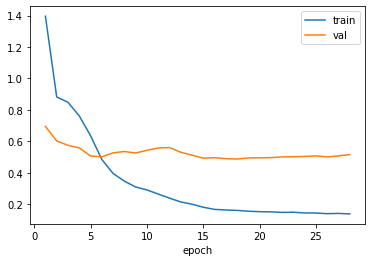

In [27]:
#Plot the training and validation losses
ax = pd.DataFrame(history).drop(columns='total').plot(x='epoch')

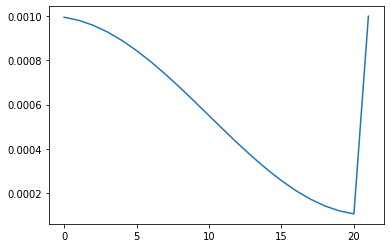

In [28]:
#Plot each epoches
_ = plt.plot(lr_history[:2*iterations_per_epoch])


In [29]:
net.load_state_dict(best_weights)

<All keys matched successfully>

In [30]:
#make prediction and evaluate the model
groud_truth, predictions = [], []

with torch.no_grad():
    for batch in batches(*datasets['val'], shuffle=False, bs=bs):
        x_batch, y_batch = [b.to(device) for b in batch]
        outputs = net(x_batch[:, 0], x_batch[:, 1], minmax)
        groud_truth.extend(y_batch.tolist())
        predictions.extend(outputs.tolist())

groud_truth = np.asarray(groud_truth).ravel()
predictions = np.asarray(predictions).ravel()

#Find the final loss
final_loss = np.sqrt(np.mean((predictions - groud_truth)**2))
print(f'Final RMSE: {final_loss:.4f}')

Final RMSE: 0.8294
